In [1]:
import sys, os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import seaborn as sns
sys.path.append(os.path.join(os.getcwd(), '..'))
from src.util import *

In [2]:
with open('../data/params.json', 'r') as f:
    params = json.load(f)

nsim = params.get('nsim', 10000)
nepisode_train = params.get('nepisode_train', 3000)
nepisode_eval = params.get('nepisode_eval', 500)
nstep = params.get('nstep', 365)
t1 = params.get('t1', 0)
k = params.get('k', 100)

with open('../data/results.pkl', 'rb') as f:
    results = pickle.load(f)

df = pd.read_csv('../data/test_cases.csv', usecols=range(0, 14))
df = df[:3] # TODO: remove!

In [3]:
# df.head()
# mean_reward, fig1, fig2 = results[0]

In [4]:
# mean_rewards = []

# mean_reward

In [5]:
# show_figure(fig1)
# plt.show()

In [3]:
# mean_rewards = []
# for index, row in df.iterrows():
#     mean_reward = results[index][0]  
#     mean_rewards.append(mean_reward)
df['RL_Price'] = [x[0] for x in results]

In [4]:
df['European_Price'] = df.apply(
    lambda row: black_scholes(
        s=row['s_0'],
        k=100, 
        t1 = 0,
        t2=row['t2'],
        r=row['r'],
        v=row['v'] if not np.isnan(row['v']) else row['sigma'],  
        q = row['q'],
        call=row['h'].split('_')[-1].lower() == "call"
    ),
    axis=1
)

In [7]:
k = 100
# call = partial(lambda x, k: np.maximum(x - k, 0), k=k)
# put = partial(lambda x, k: np.maximum(k - x, 0), k=k)

df['MC_Price'] = df.apply(
    lambda row: get_mc_price(
        generate_gbm_paths(
            nsim=1000,
            # nstep=int(12 * row["t2"]),  
            nstep=365,
            t1=0,
            t2=row["t2"],
            s_0=row["s_0"],
            r=row["r"],
            q=row["q"],
            v=row["v"]
        ) if row["gbm"] else generate_heston_paths(
            nsim=1000,
            # nstep=int(12 * row["t2"]),
            nstep=365,
            t1=0,
            t2=row["t2"],
            s_0=row["s_0"],
            r=row["r"],
            q=row["q"],
            v_0=row["v_0"],
            theta=row["theta"],
            rho=row["rho"],
            kappa=row["kappa"],
            sigma=row["sigma"]
        ),
        t1=0,
        t2=row["t2"],
        h=(call if row["h"].split('_')[-1].lower() == "call" else put), 
        k=k,
        r=row["r"]
    ),
    axis=1
)

In [8]:
# Value of Early Exercise
df['Early_Exe_Value_RL'] = df['RL_Price'] - df['European_Price']
df['Early_Exe_Value_MC'] = df['MC_Price'] - df['European_Price']

## Testing pricing consistency/accuracy on American Put-Options

In [9]:
# df[(df["case"] == "Base_Case") ]

In [10]:
# #df[(df["case"] == "Base_Case") & (df["gbm"] == True)]
# df[(df["case"] == "Base_Case") ]

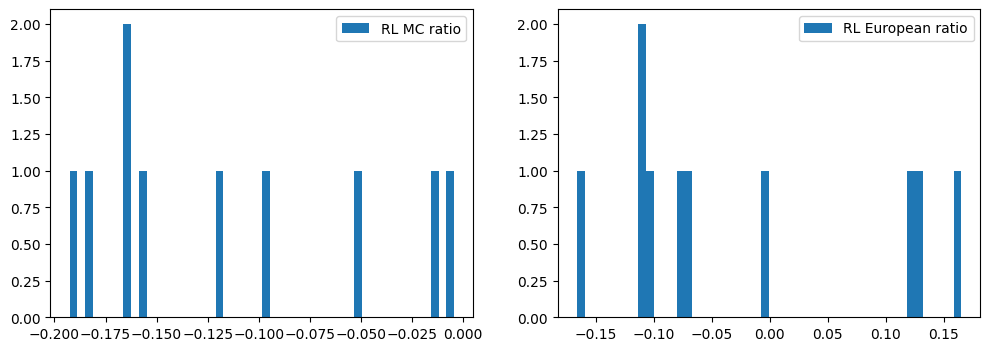

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for ax, col in zip(axes.flatten(), ('MC_Price', 'European_Price')):
    ax.hist((df['RL_Price'] - df[col]) / df[col], bins=50, label=f"RL {col.split('_')[0]} ratio")
    ax.legend()
plt.show()

Plots

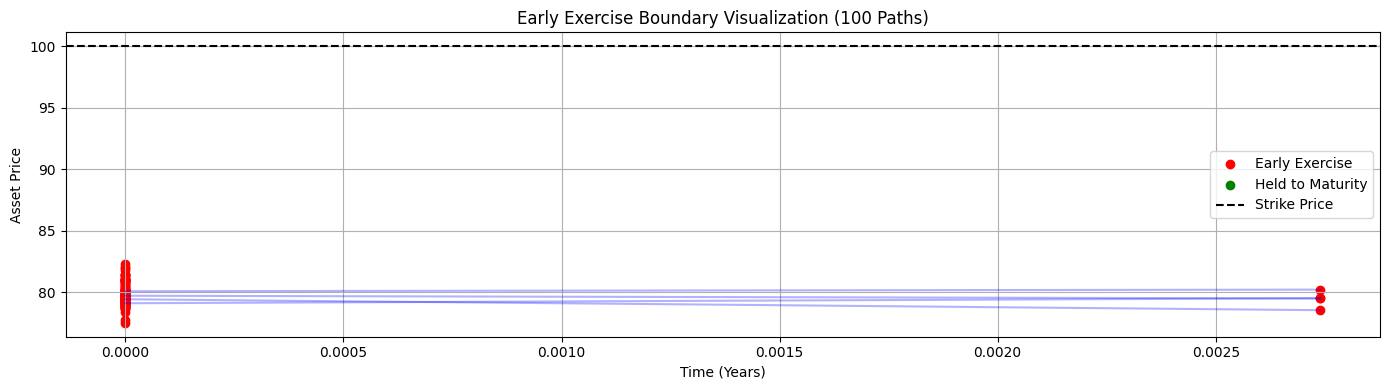

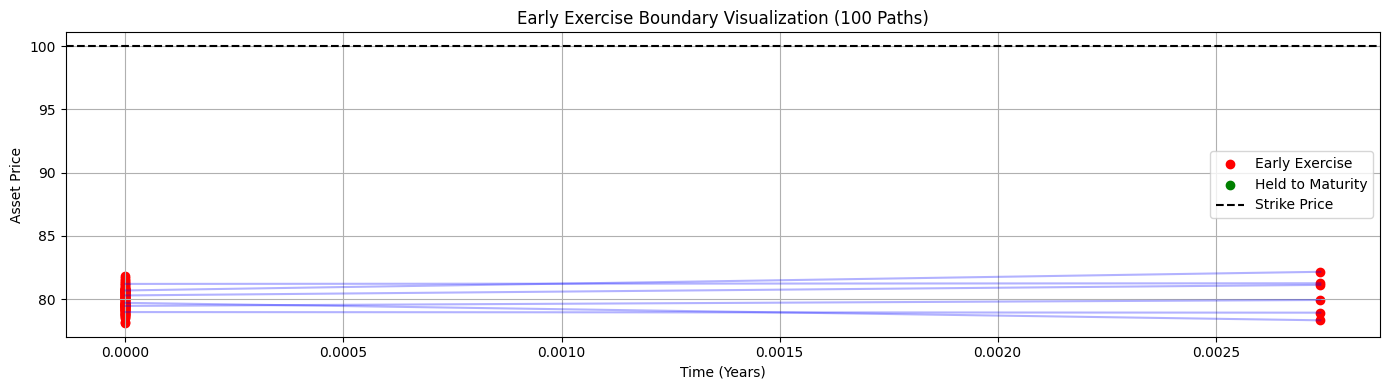

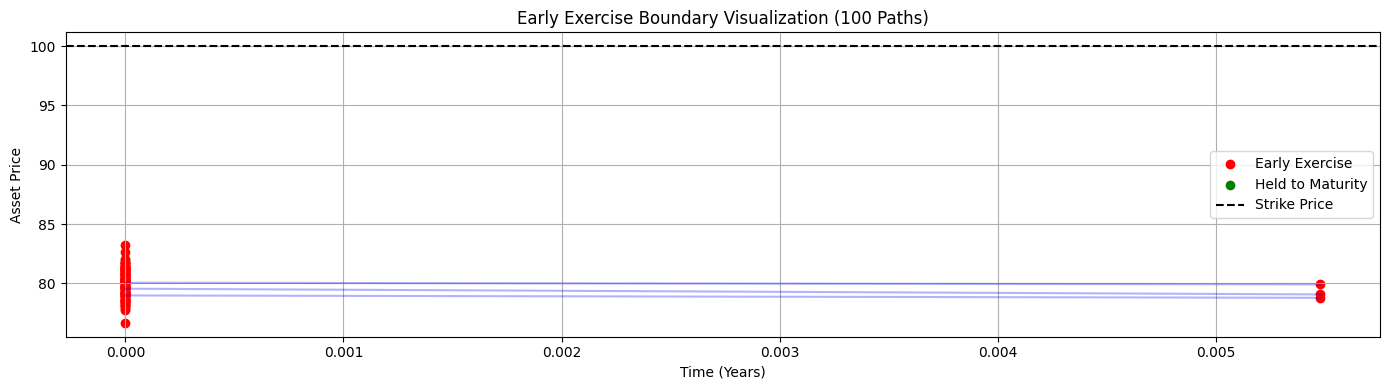

In [3]:
for result in results:
    mean_reward, fig1, fig2 = result
    show_figure(fig2)

In [13]:
# # Function to plot RL, MC, and European prices comparison
# def plot_prices_comparison(df, title="Price Comparison Across Cases"):
#     plt.figure(figsize=(12, 8))
#     x = range(len(df))
#     plt.plot(x, df['RL_Price'], marker='o', label='RL Price', linestyle='-', linewidth=2)
#     plt.plot(x, df['MC_Price'], marker='x', label='MC Price', linestyle='--', linewidth=2)
#     plt.plot(x, df['European_Price'], marker='^', label='European Price', linestyle='-.', linewidth=2)
#     plt.title(title)
#     plt.xlabel("Test Case Index")
#     plt.ylabel("Option Price")
#     plt.legend()
#     plt.show()

# # Function to plot early exercise value comparison
# def plot_early_exercise_comparison(df, title="Early Exercise Value Comparison"):
#     plt.figure(figsize=(12, 8))
#     x = range(len(df))
#     plt.plot(x, df['Early_Exe_Value_RL'], label="Early Exercise Value (RL)", marker='o', linestyle='-', linewidth=2)
#     plt.plot(x, df['Early_Exe_Value_MC'], label="Early Exercise Value (MC)", marker='x', linestyle='--', linewidth=2)
#     plt.title(title)
#     plt.xlabel("Test Case Index")
#     plt.ylabel("Early Exercise Value")
#     plt.legend()
#     plt.show()

# # Plot RL vs MC vs European Prices
# plot_prices_comparison(df, title="Comparison of RL, MC, and European Prices")

# # Plot Early Exercise Values
# plot_early_exercise_comparison(df, title="Comparison of Early Exercise Value (RL vs MC)")


In [14]:
# # Function to compare standardized price differences as a bar plot
# def plot_standardized_price_differences(df, title="Standardized Price Differences: (RL - MC) / MC"):
#     df['Standardized_Diff'] = (df['RL_Price'] - df['MC_Price']) / df['MC_Price']
#     plt.figure(figsize=(12, 6))
#     sns.barplot(data=df, x='case', y='Standardized_Diff', ci=None)
#     plt.title(title)
#     plt.xlabel("Test Case Category")
#     plt.ylabel("Standardized Difference: (RL Price - MC Price) / MC Price")
#     plt.xticks(rotation=45)
#     plt.axhline(0, color='black', linewidth=1)  # Reference line at 0
#     plt.show()

# # Plot standardized price differences between RL and MC
# plot_standardized_price_differences(df, title="Standardized Differences Between RL and MC Prices Across Cases")

In [15]:
# def show_fig2_with_params(results, df):
#     for idx, result in enumerate(results):
#         fig2 = result[4] 
#         if fig2 is not None:
#             params = df.iloc[idx]
#             param_text = (
#                 f"So: {params['s_0']}, σ: {params['v'] or params['sigma']}, "
#                 f"T: {params['t2']}, r: {params['r']}, "
#                 f"Option: {params['h']}"
#             )
            
#             fig2.suptitle(param_text, fontsize=10, color='blue')
            
            
#             plt.figure(fig2.number) 
#             show_figure(fig2)

# show_fig2_with_params(results, df)